In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import re
import gspread
import json
import os
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [2]:
file_data = json.load(open(os.path.expanduser("../../../ServiceAccountsKey.json")))
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(
    ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

ruland_gs = gc.open_by_url(
    "https://docs.google.com/spreadsheets/d/1od248fJpNbwMO8IVZQVO3xnzrmmTe68yS9XWajyuk5o/edit?usp=sharing")

In [3]:
lexeme_df = pd.read_parquet("../data/large_files/ruland-emlap-grela.parquet")

In [4]:
len(lexeme_df)

2846

In [5]:
lexeme_df.loc[1780]

Lemma                                                       Machina, Axia
lemmas_all                                                [Machina, Axia]
target_canonical                                            machina, axia
entry_ids                                      [Ruland1612-Machina,-Axia]
entry_count                                                             1
types                                                                 [M]
variants                                                               []
notes                                                                  []
senses_flat             [{'def': 'axis stratus', 'entry_id': 'Ruland16...
sense_count                                                             1
sense_def_all                                              [axis stratus]
sense_def_strict_all                                       [axis stratus]
sense_raw_all                                    [, axis stratus. Welle.]
translations_all        [{'entry_id': 

In [9]:
emlap_metadata = pd.read_csv(
        "https://raw.githubusercontent.com/CCS-ZCU/EMLAP_ETL/refs/heads/master/data/emlap_metadata.csv",
        sep=";",
    )
emlap_metadata.head(5)

Unnamed: 0.1  Unnamed: 0                 working_title  \
0             0           0        Augurello, Chrysopoeia   
1             1           1         Pseudo-Lull, Secretis   
2             2           2  Pantheus, Ars Transmutatione   
3             3           3          Anon, Vera alchemiae   
4             4           4        Pantheus, Voarchadumia   

                                           filenames     no.  is_done  \
0       100001_Augurello1515_Chrysopoeia_GB_Noscemus  100001     True   
1  100002_Pseudo-Lull1518_De secretis_naturae_MDZ...  100002     True   
2  100003_Pantheus1518_Ars_Transmutationis_Metall...  100003     True   
3            100004_Anon1561_Verae_Alchemiae_MDZ_MBS  100004     True   
4               100005_Pantheus1530_Voarchadumia_ONB  100005     True   

   is_noscemus  if_noscemus_id  AUTHORSHIP  is_one_author  ...  CONTENTS  \
0         True        713324.0         NaN           True  ...       NaN   
1        False             NaN         NaN           True  ...       NaN   
2        False             NaN         NaN           True  ...       NaN   
3        False             NaN         NaN           True  ...       NaN   
4        False             NaN         NaN           True  ...       NaN   

                     genre            subject SOURCE OF FILE  \
0            didactic poem            alchemy            NaN   
1                 treatise  alchemy, medicine            NaN   
2                 treatise            alchemy            NaN   
3  compendium, florilegium            alchemy            NaN   
4                 treatise            alchemy            NaN   

                                                link source_of_file  \
0       https://wiki.uibk.ac.at/noscemus/Chrysopoeia             GB   
1  https://www.digitale-sammlungen.de/en/view/bsb...            MDZ   
2  https://www.google.co.uk/books/edition/Ars_Tra...             GB   
3   https://mdz-nbn-resolving.de/details:bsb10141168            MDZ   
4                https://data.onb.ac.at/rep/10588E49            ONB   

  origin_of_copy  other_notes tokens_N  aurhor_wd  
0       Noscemus          NaN    23225        NaN  
1            MBS          NaN    24696        NaN  
2             BL          NaN     8683        NaN  
3            MBS          NaN   368660        NaN  
4            ONB          NaN    21175        NaN  

[5 rows x 57 columns]

In [11]:
emlap_metadata["tokens_N"].sum()

np.int64(6477016)

In [12]:
# to work excusively with works from the older period
#emlap_metadata = emlap_metadata[emlap_metadata["date_publication"]<=1600]

In [13]:
emlap_metadata.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'working_title', 'filenames', 'no.',
       'is_done', 'is_noscemus', 'if_noscemus_id', 'AUTHORSHIP',
       'is_one_author',
       '#if more than 1 author skip section and choose compendium below',
       'is_author_known', 'author_name', 'author_name_alternatives',
       'author_viaf', 'author_cerl', 'author_comments', 'is_compendium',
       'if_compendium', 'TRANSLATION / EDITORSHIP', 'is_translator',
       'translator_name', 'translator_name_alternatives',
       'translator_comments', 'is_editor', 'editor_name',
       'editor_name_alternatives', 'editor_comments', 'DATE OF PUBLICATION',
       'date_publication', 'date_certainty', 'date_not_after',
       'date_not_before', 'date_comment', 'TITLE', 'title_short', 'title_full',
       'title_viaf', 'title_comments', 'PLACE OF PUBLICATION',
       'place_publication', 'place_geonames', 'place_comments', 'PUBLISHER',
       'publisher_name', 'publisher_name_alternatives', 'publisher_comments'

In [14]:
emlap_metadata["labeldate"] = emlap_metadata.apply(lambda row: row["working_title"] + " ({})".format(str(row["date_publication"])), axis=1)

In [15]:
emlap_metadata.sort_values("date_publication", ascending=True, inplace=True)

## Exploring individual entries

In [16]:
# emlap_id_label_dict = dict(zip(emlap_metadata["No."], emlap_metadata["labeldate"]))

In [17]:
def extract_emlap_ids(emlap_instances):
    return [instance["grela_id"][6:] for instance in emlap_instances]

lexeme_df["instances_ids"] = lexeme_df["emlap_instances"].apply(extract_emlap_ids)

In [37]:
def make_plot_bar(entry):
    # Get instance IDs for the entry
    instances_ids = lexeme_df[lexeme_df["Lemma"] == entry]["instances_ids"].tolist()[0]
    counter = Counter(instances_ids)

    # Extract the keys (labels) and their corresponding counts (frequencies)
    emlap_metadata_instances = emlap_metadata.copy()
    emlap_metadata_instances["Frequency"] = (
        emlap_metadata_instances["no."].astype(str).map(counter).fillna(0).astype(int)
    )

    # Add bidecade labels to the DataFrame
    def get_bidecade_label(year):
        if not np.isnan(year):  # Handle NaN years safely
            start = (year // 20) * 20  # Determine the starting year of the bidecade
            end = start + 19  # Determine the ending year of the bidecade
            return f"{start}-{end}"
        return None

    emlap_metadata_instances["Bidecade"] = emlap_metadata_instances["date_publication"].apply(get_bidecade_label)

    # Group by Bidecade and sum frequencies and tokens_N
    emlap_instances_grouped = (
        emlap_metadata_instances.groupby("Bidecade", dropna=True)[["Frequency", "tokens_N"]]
        .sum()
        .reset_index()
    )

    # Sort bidecade intervals numerically
    emlap_instances_grouped = emlap_instances_grouped.sort_values(
        by="Bidecade",
        key=lambda col: col.str.extract(r"(\d+)")[0].astype(int)
    )

    # Calculate relative frequency (Frequency / tokens_N)
    emlap_instances_grouped["RelativeFrequency"] = (
        emlap_instances_grouped["Frequency"] / emlap_instances_grouped["tokens_N"]
    )

    # Calculate relative frequency for individual works
    emlap_metadata_instances["RelativeFrequency"] = (
        emlap_metadata_instances["Frequency"] / emlap_metadata_instances["tokens_N"]
    )

    # Create the 4 subplots (2x2 layout)
    fig, axes = plt.subplots(2, 2, figsize=(30, 12), dpi=300)

    # Plot 1: Absolute frequency vs. bidecades
    ax1 = axes[0, 0]
    ax1.bar(
        emlap_instances_grouped["Bidecade"],
        emlap_instances_grouped["Frequency"],
        color="blue"
    )
    ax1.set_xlabel("Bidecades", fontsize=12)
    ax1.set_ylabel("Absolute Frequency", fontsize=12)
    ax1.set_title(f"Absolute Frequency of '{entry}' by Bidecades", fontsize=14)
    ax1.set_xticks(range(len(emlap_instances_grouped["Bidecade"])))
    ax1.set_xticklabels(emlap_instances_grouped["Bidecade"], rotation=90)

    # Plot 2: Relative frequency vs. bidecades
    ax2 = axes[0, 1]
    ax2.bar(
        emlap_instances_grouped["Bidecade"],
        emlap_instances_grouped["RelativeFrequency"],
        color="orange"
    )
    ax2.set_xlabel("Bidecades", fontsize=12)
    ax2.set_ylabel("Relative Frequency (Frequency / tokens_N)", fontsize=12)
    ax2.set_title(f"Relative Frequency of '{entry}' by Bidecades", fontsize=14)
    ax2.set_xticks(range(len(emlap_instances_grouped["Bidecade"])))
    ax2.set_xticklabels(emlap_instances_grouped["Bidecade"], rotation=90)

    # Plot 3: Absolute frequency vs. works
    ax3 = axes[1, 0]
    ax3.bar(
        emlap_metadata_instances["labeldate"],
        emlap_metadata_instances["Frequency"],
        color="blue"
    )
    ax3.set_xlabel("Works", fontsize=12)
    ax3.set_ylabel("Absolute Frequency", fontsize=12)
    ax3.set_title(f"Absolute Frequency of '{entry}' by Works", fontsize=14)
    ax3.set_xticks(range(len(emlap_metadata_instances["labeldate"])))
    ax3.set_xticklabels(emlap_metadata_instances["labeldate"], rotation=90, fontsize=9)

    # Plot 4: Relative frequency vs. works
    ax4 = axes[1, 1]
    ax4.bar(
        emlap_metadata_instances["labeldate"],
        emlap_metadata_instances["RelativeFrequency"],
        color="orange"
    )
    ax4.set_xlabel("Works", fontsize=12)
    ax4.set_ylabel("Relative Frequency (Frequency / tokens_N)", fontsize=12)
    ax4.set_title(f"Relative Frequency of '{entry}' by Works", fontsize=14)
    ax4.set_xticks(range(len(emlap_metadata_instances["labeldate"])))
    ax4.set_xticklabels(emlap_metadata_instances["labeldate"], rotation=90, fontsize=9)

    # Adjust layout and display the plots
    plt.tight_layout()
    #plt.show()
    return fig

In [34]:
entry = "Lapis philosophorum"
instances_ids = lexeme_df[lexeme_df["Lemma"] == entry]["instances_ids"].tolist()[0]
counter = Counter(instances_ids)
emlap_metadata_instances = emlap_metadata.copy()
emlap_metadata_instances["Frequency"] = (
        emlap_metadata_instances["no."].astype(str).map(counter).fillna(0).astype(int))

In [35]:
emlap_metadata_instances.head(5)

Unnamed: 0.1  Unnamed: 0                    working_title  \
0              0           0           Augurello, Chrysopoeia   
1              1           1            Pseudo-Lull, Secretis   
2              2           2     Pantheus, Ars Transmutatione   
8              8           8  Vegius, Inter inferiora corpora   
12            12          12                  Ulstadt, Coelum   

                                            filenames     no.  is_done  \
0        100001_Augurello1515_Chrysopoeia_GB_Noscemus  100001     True   
1   100002_Pseudo-Lull1518_De secretis_naturae_MDZ...  100002     True   
2   100003_Pantheus1518_Ars_Transmutationis_Metall...  100003     True   
8   100009_Vegius1518_Inter_inferiora_corpora_disp...  100009     True   
12  100013_Ulstad1525_Coelum_philosophorum_Medica_...  100013     True   

    is_noscemus  if_noscemus_id  AUTHORSHIP  is_one_author  ...  \
0          True        713324.0         NaN           True  ...   
1         False             NaN         NaN           True  ...   
2         False             NaN         NaN           True  ...   
8         False             NaN         NaN          False  ...   
12        False             NaN         NaN           True  ...   

                   subject  SOURCE OF FILE  \
0                  alchemy             NaN   
1        alchemy, medicine             NaN   
2                  alchemy             NaN   
8   Renaissance philosophy             NaN   
12   alchemy, quintessence             NaN   

                                                 link source_of_file  \
0        https://wiki.uibk.ac.at/noscemus/Chrysopoeia             GB   
1   https://www.digitale-sammlungen.de/en/view/bsb...            MDZ   
2   https://www.google.co.uk/books/edition/Ars_Tra...             GB   
8                  http://data.onb.ac.at/rep/1099703B            ONB   
12  https://www.biusante.parisdescartes.fr/histmed...         Medica   

   origin_of_copy other_notes tokens_N  aurhor_wd  \
0        Noscemus         NaN    23225        NaN   
1             MBS         NaN    24696        NaN   
2              BL         NaN     8683        NaN   
8             ONB         NaN    27814        NaN   
12          BIUSP         NaN    41603  Q18026923   

                                 labeldate  Frequency  
0            Augurello, Chrysopoeia (1515)          0  
1             Pseudo-Lull, Secretis (1518)          4  
2      Pantheus, Ars Transmutatione (1518)          0  
8   Vegius, Inter inferiora corpora (1518)          0  
12                  Ulstadt, Coelum (1525)          7  

[5 rows x 59 columns]

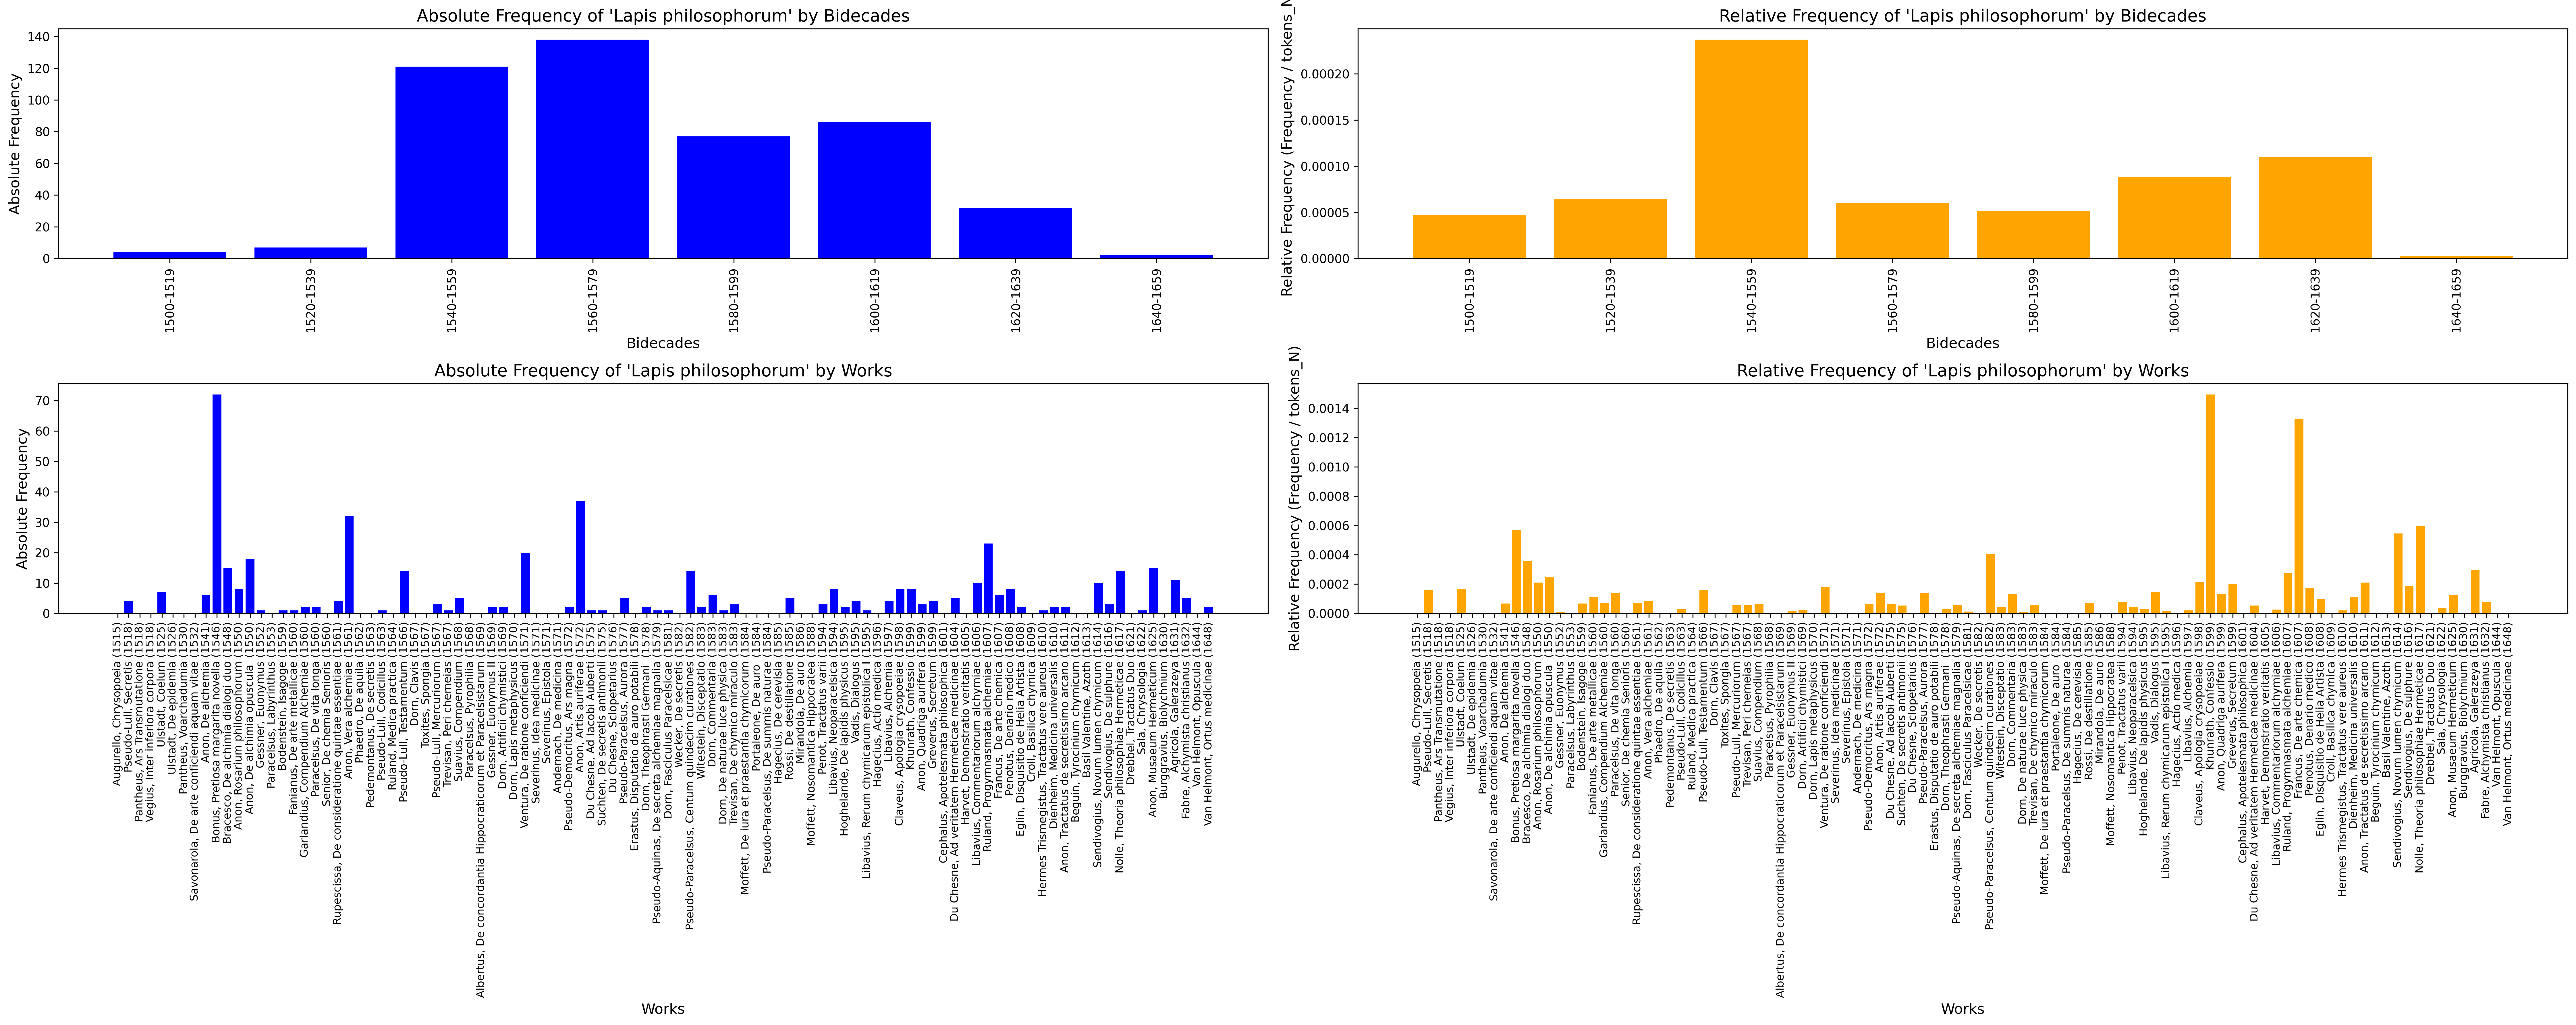

In [38]:
entry = "Lapis philosophorum"
fig = make_plot_bar(entry)

In [39]:
fig.savefig("../figures/casestudy_lapis_philosophorum.png", dpi=300)

## Overview

In [16]:
lexeme_df["emlap_instances_N"].sum()

np.int64(235182)

In [17]:
lexeme_df.sort_values("emlap_instances_N", ascending=False)[:10]

Lemma   lemmas_all target_canonical  \
472        Aqua       [Aqua]             aqua   
1045     Corpus     [Corpus]           corpus   
76        Ignis      [Ignis]            ignis   
599       Aurum      [Aurum]            aurum   
529    Argentum   [Argentum]         argentum   
29        Oleum      [Oleum]            oleum   
2495   Spiritus   [Spiritus]         spiritus   
97     Metallum   [Metallum]         metallum   
10      Sulphur    [Sulphur]          sulphur   
27    Mercurius  [Mercurius]        mercurius   
2280        Sal        [Sal]              sal   
1203  Elementum  [Elementum]        elementum   
200         Aer        [Aer]              aer   
2466        Sol        [Sol]              sol   
18     Essentia   [Essentia]         essentia   
2163     Puluis     [Puluis]           puluis   
2839      Anima      [Anima]            anima   
159      Acetum     [Acetum]           acetum   
90         Luna       [Luna]             luna   
2767      Vncia      [Vncia]            uncia   

                                              entry_ids  entry_count types  \
472                                   [Ruland1612-Aqua]            1   [A]   
1045                                [Ruland1612-Corpus]            1   [C]   
76                 [Ruland1612-Ignis, Ruland1612-Ignis]            2   [I]   
599                                  [Ruland1612-Aurum]            1   [A]   
529   [Ruland1612-Argentum-à-Chymistis-Luna,-cui-eti...            1   [A]   
29    [Ruland1612-Oleum, Ruland1612-Oleum, Ruland161...            3   [O]   
2495                              [Ruland1612-Spiritus]            1   [S]   
97           [Ruland1612-Metallum, Ruland1612-Metallum]            2   [M]   
10    [Ruland1612-Sulphur, Ruland1612-Sulphur, Rulan...            4   [S]   
27    [Ruland1612-Mercurius, Ruland1612-Mercurius, R...            3   [M]   
2280                                   [Ruland1612-Sal]            1   [S]   
1203                             [Ruland1612-Elementum]            1   [E]   
200                                    [Ruland1612-Aer]            1   [A]   
2466                                   [Ruland1612-Sol]            1   [S]   
18    [Ruland1612-Essentia, Ruland1612-Essentia, Rul...            3   [E]   
2163                                [Ruland1612-Puluis]            1   [P]   
2839                                 [Ruland1612-Anima]            1   [A]   
159                                 [Ruland1612-Acetum]            1   [A]   
90                   [Ruland1612-Luna, Ruland1612-Luna]            2   [L]   
2767                                 [Ruland1612-Vncia]            1   [V]   

        variants                                              notes  \
472           []  [1. Dieses Wasser reiniget/maschet/meitet/mach...   
1045          []                                                 []   
76            []                                                 []   
599           []  [Natiuum purum, quod a natura tale est, cuius ...   
529   [Argentum]                                                 []   
29            []                                                 []   
2495          []                                                 []   
97            []                                                 []   
10            []                                                 []   
27            []                                                 []   
2280          []                                                 []   
1203          []                                                 []   
200           []                                                 []   
2466          []                                                 []   
18            []                                                 []   
2163          []                                                 []   
2839          []  [] Wie die Philosophen drey principia machen S...   
159           []                                               

In [74]:
set_with_dataframe(ruland_gs.add_worksheet("ruland_top10", 1,1), lexeme_df[['Lemma', 'target_canonical', 'target_relemmatized', 'emlap_instances_N']].sort_values("emlap_instances_N", ascending=False)[:10])

In [20]:
lexeme_df[['Lemma', 'target_canonical', 'target_relemmatized', 'emlap_instances_N']].sort_values("emlap_instances_N", ascending=False).to_csv("../data/lexeme_df_instances.csv")

In [19]:
lexeme_df[lexeme_df["target_len"]>1].sort_values("emlap_instances_N", ascending=False)[:10]


Lemma             lemmas_all     target_canonical  \
33        Quinta essentia      [Quinta essentia]      quinta essentia   
497            Aqua vitae           [Aqua vitae]           aqua uitae   
481           Aqua fortis          [Aqua fortis]          aqua fortis   
605        Aurum potabile       [Aurum potabile]       aurum potabile   
47         Balneum Mariae       [Balneum Mariae]       balneum mariae   
1701  Lapis philosophorum  [Lapis philosophorum]  lapis philosophorum   
792       Calor naturalis      [Calor naturalis]      calor naturalis   
1848        Materia prima        [Materia prima]        materia prima   
1243      Essentia quinta      [Essentia quinta]      essentia quinta   
2306            Sal nitri            [Sal nitri]            sal nitri   

                                              entry_ids  entry_count types  \
33    [Ruland1612-Quinta-essentia, Ruland1612-Quinta...            3   [Q]   
497                             [Ruland1612-Aqua-vitae]            1   [A]   
481                            [Ruland1612-Aqua-fortis]            1   [A]   
605                         [Ruland1612-Aurum-potabile]            1   [A]   
47    [Ruland1612-Balneum-Mariae, Ruland1612-Balneum...            2   [B]   
1701                   [Ruland1612-Lapis-philosophorum]            1   [L]   
792                        [Ruland1612-Calor-naturalis]            1   [C]   
1848                         [Ruland1612-Materia-prima]            1   [M]   
1243                       [Ruland1612-Essentia-quinta]            1   [E]   
2306                             [Ruland1612-Sal-nitri]            1   [S]   

     variants notes                                        senses_flat  \
33         []    []  [{'def': 'est natura vires, virtus color vita,...   
497        []    []  [{'def': 'id est, Mercurius', 'entry_id': 'Rul...   
481        []    []  [{'def': 'est, quae ex auibus, & corrosiuis ce...   
605        []    []  [{'def': 'est liquor, sine corrosiuo, quod pau...   
47         []    []  [{'def': 'id est, aqua calida.', 'entry_id': '...   
1701       []    []  [{'def': 'sein die Haar der Menschen.', 'entry...   
792        []    []  [{'def': 'est, quando radii solares, vel per s...   
1848       []    []  [{'def': '& huius vocabula,', 'entry_id': 'Rul...   
1243       []    []  [{'def': 'est materia corpporalis ex omnib. qu...   
2306       []    []  [{'def': 'ex terra decoquitur, in qua vrina di...   

      sense_count                                      sense_def_all  \
33              3  [est natura vires, virtus color vita, spiritus...   
497             1                                [id est, Mercurius]   
481             1  [est, quae ex auibus, & corrosiuis certa propo...   
605             1  [est liquor, sine corrosiuo, quod paucissimi n...   
47              2  [id est, aqua calida., est furnus destillatori...   
1701            1                      [sein die Haar der Menschen.]   
792             1  [est, quando radii solares, vel per se materia...   
1848            1                                [& huius vocabula,]   
1243            1  [est materia corpporalis ex omnib. quib. vita ...   
2306            1  [ex terra decoquitur, in qua vrina diutissime ...   

                                   sense_def_strict_all  \
33    [est natura vires, virtus color vita, spiritus...   
497                                 [id est, Mercurius]   
481   [est, quae ex auibus, & corrosiuis certa propo...   
605   [est liquor, sine corrosiuo, quod paucissimi n...   
47    [id est, aqua calida., est furnus destillatori...   
1701                      [sein die Haar der Menschen.]   
792   [est, quando radii solares, vel per se materia...   
1848                                [& huius vocabula,]   
1243  [est materia corpporalis ex omnib. quib. vita ...   
2306  [ex terra decoquitur, in qua vrina diutissime ...   

                                          sense_raw_all  \
33    [est natura vires, virtus color vi

## Distributions of EMLAP works

In [22]:
lexeme_df["instances_counter"] = lexeme_df["instances_ids"].apply(Counter)

In [23]:
lexeme_df["instances_counter"].tolist()[:10]

[Counter({'100012': 3, '100038': 1, '100063': 1, '100070': 1}),
 Counter(),
 Counter({'100070': 101,
          '100034': 96,
          '100015': 39,
          '100075': 36,
          '100044': 35,
          '100067': 35,
          '100032': 15,
          '100038': 12,
          '100012': 11,
          '100030': 9,
          '100005': 7,
          '100043': 7,
          '100046': 7,
          '100049': 7,
          '100011': 6,
          '100026': 6,
          '100039': 6,
          '100010': 4,
          '100013': 4,
          '100020': 4,
          '100028': 4,
          '100016': 3,
          '100027': 3,
          '100073': 3,
          '100001': 2,
          '100002': 2,
          '100036': 2,
          '100037': 2,
          '100040': 2,
          '100051': 2,
          '100053': 2,
          '100059': 2,
          '100064': 2,
          '100068': 2,
          '100007': 1,
          '100023': 1,
          '100050': 1,
          '100058': 1,
          '100060': 1,
          '100062

In [24]:
distribution = sum(lexeme_df["instances_counter"], Counter())

In [25]:
distribution

Counter({'100038': 22059,
         '100070': 21353,
         '100067': 12168,
         '100032': 9804,
         '100015': 9100,
         '100016': 8780,
         '100075': 7531,
         '100012': 7273,
         '100011': 6929,
         '100028': 6809,
         '100022': 6628,
         '100074': 5599,
         '100071': 5423,
         '100044': 4968,
         '100049': 4383,
         '100045': 4067,
         '100020': 3900,
         '100059': 3870,
         '100010': 3806,
         '100030': 3770,
         '100040': 3633,
         '100064': 3374,
         '100013': 3362,
         '100007': 3312,
         '100063': 3206,
         '100034': 2985,
         '100046': 2916,
         '100025': 2639,
         '100060': 2638,
         '100026': 2574,
         '100033': 2505,
         '100056': 2330,
         '100039': 1997,
         '100068': 1918,
         '100043': 1913,
         '100035': 1789,
         '100021': 1688,
         '100051': 1636,
         '100050': 1629,
         '100036': 161

In [ ]:
df = emlap_metadata.copy()
df["Frequency"] = (
        df["no."].astype(str).map(distribution).fillna(0).astype(int)
    )
df["RelativeFrequency"] = df["Frequency"] / df["tokens_N"]

    # Sort by publication date for a chronological x-axis
# df = df.sort_values(["date_publication", "labeldate"], na_position="last")



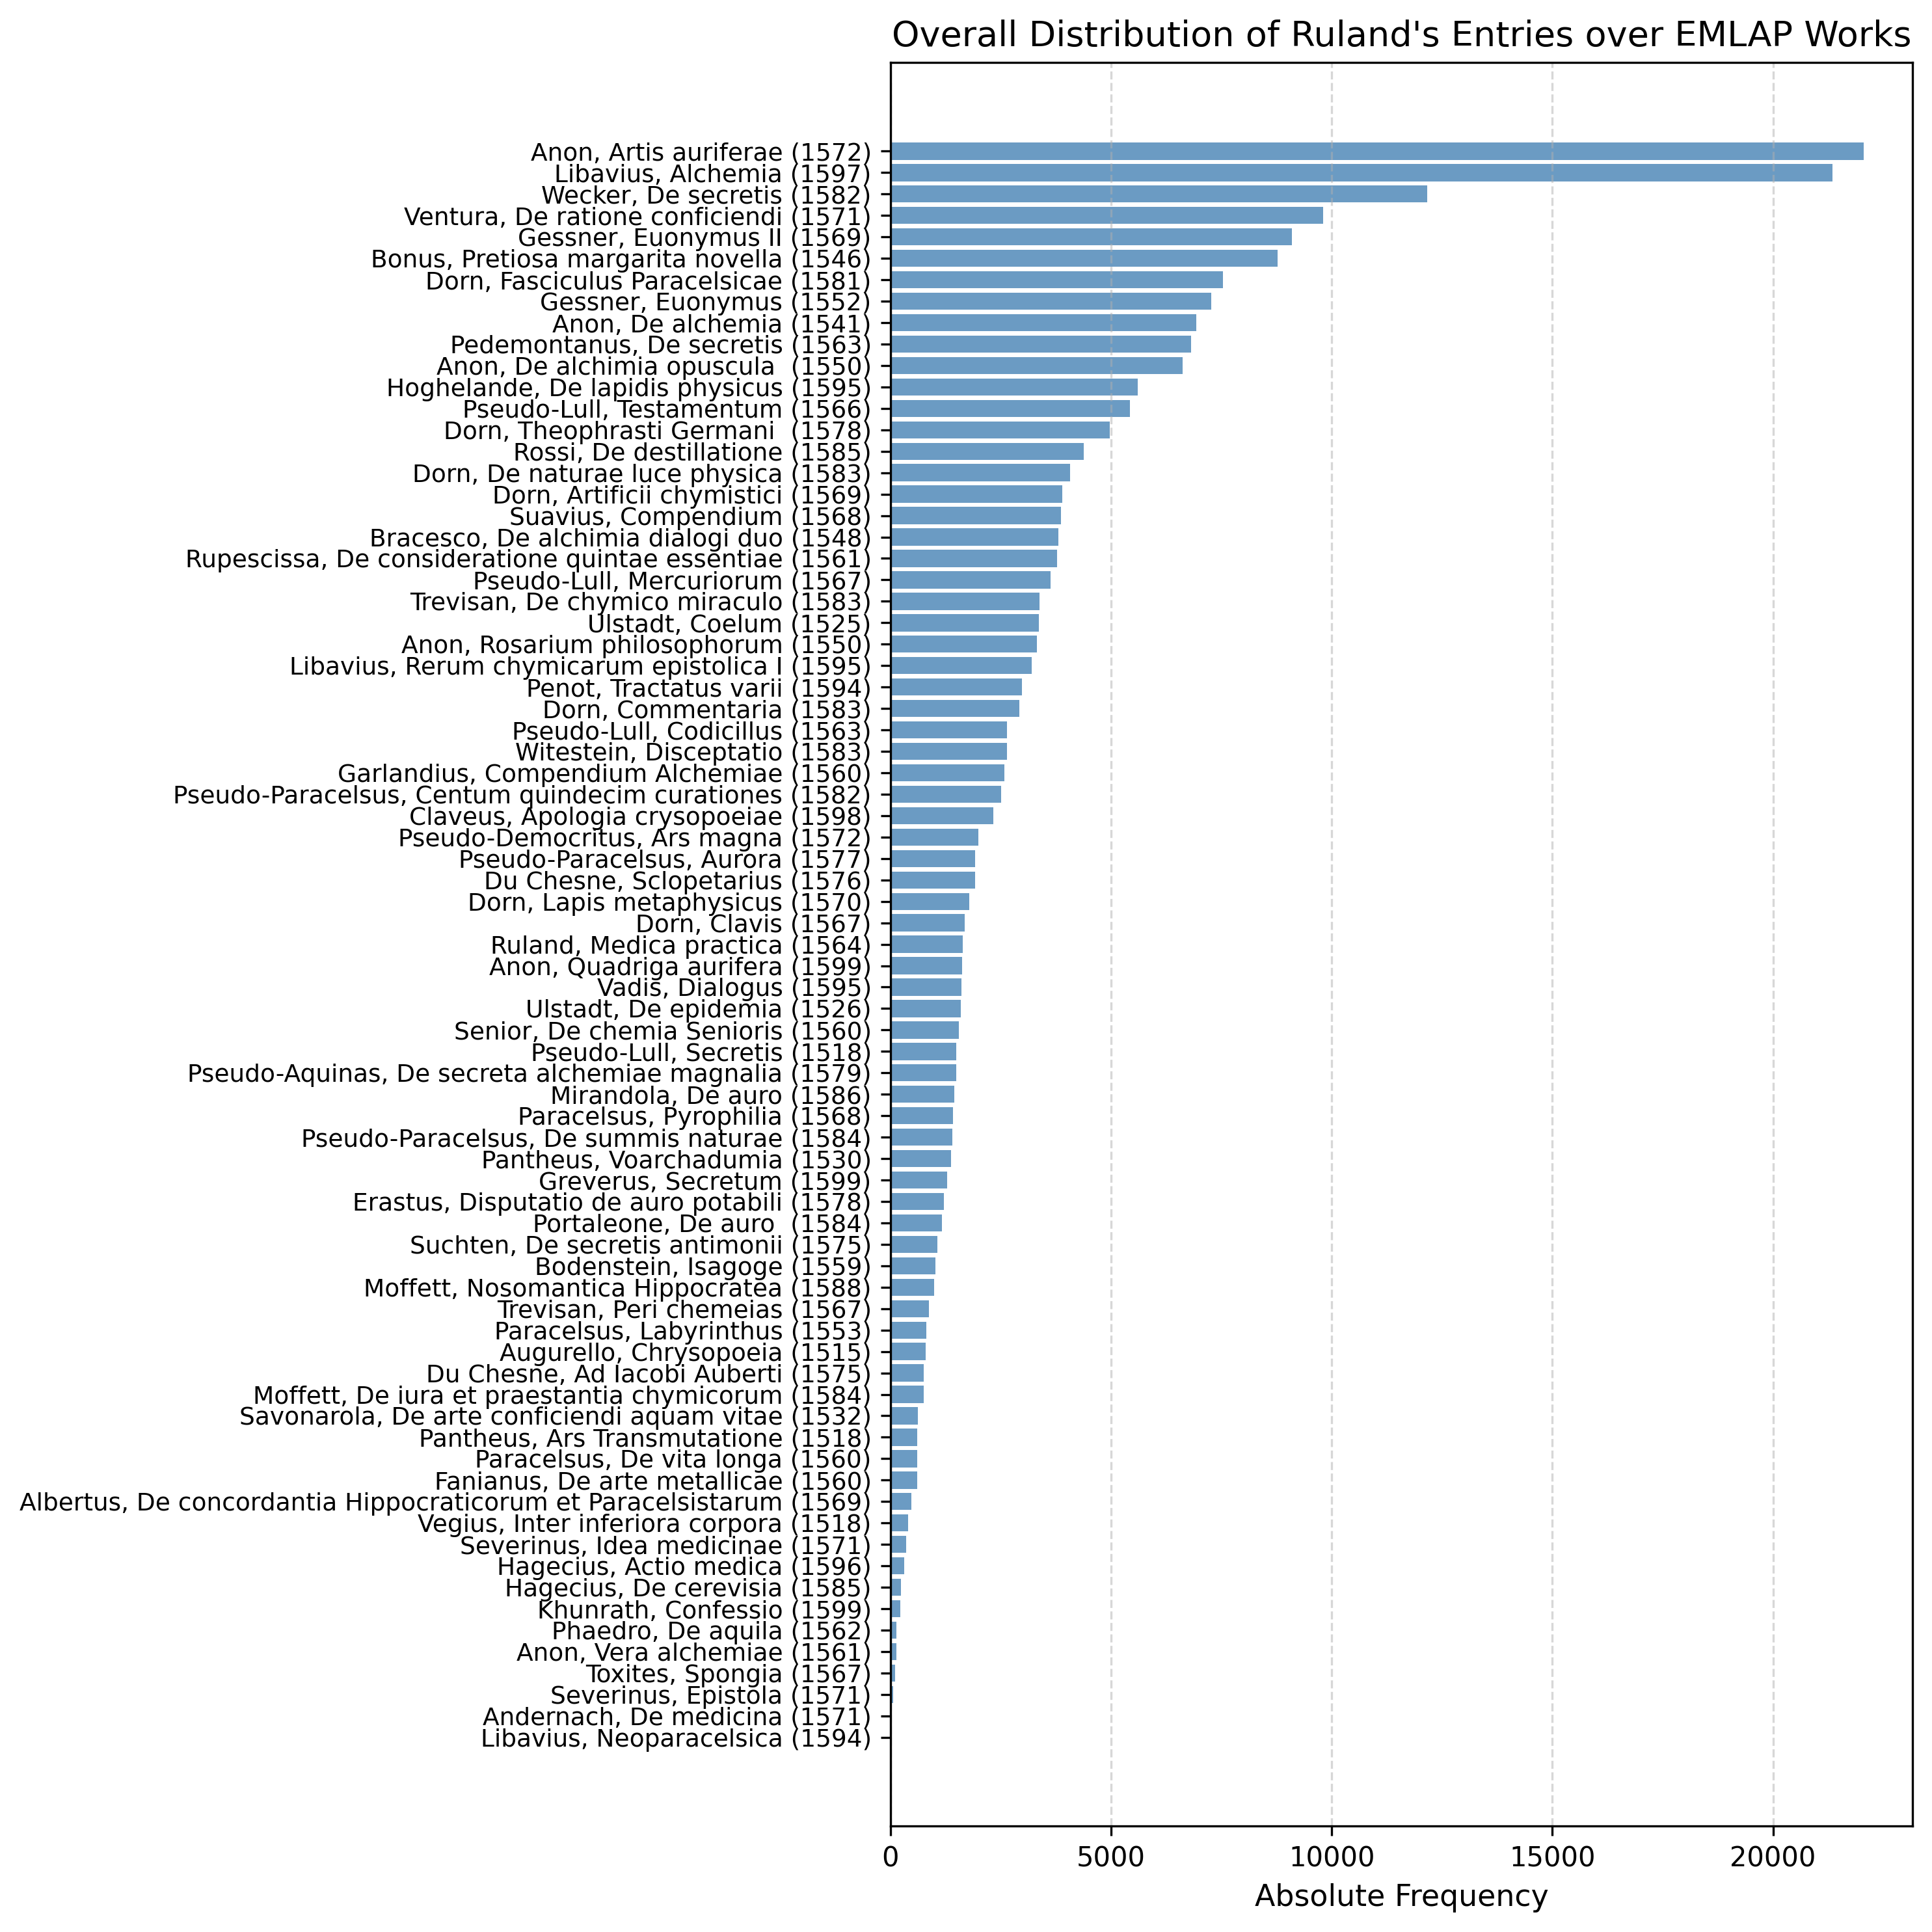

In [60]:
# Sort descending by Frequency
df = df.sort_values("Frequency", ascending=False)

# Prepare labels and positions
x_labels = df["labeldate"].tolist()
y_pos = np.arange(len(x_labels))

# Title
title = "Overall Distribution of Ruland's Entries over EMLAP Works"

# Create the figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=300, tight_layout=True)

# Horizontal bar plot (sorted)
ax.barh(y_pos, df["Frequency"].to_numpy(), color="steelblue", alpha=0.8)

# Labeling
ax.set_yticks(y_pos)
ax.set_yticklabels(x_labels, fontsize=9)
ax.invert_yaxis()  # Highest at the top
ax.set_xlabel("Absolute Frequency", fontsize=11)
ax.set_title(title, fontsize=13)

# Add gridlines for readability
ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [62]:
df[-5:]["tokens_N"]

3     3521
13    2667
7     2265
71       0
64       0
Name: tokens_N, dtype: int64

[Text(0, 0, 'Augurello, Chrysopoeia (1515)'),
 Text(1, 0, 'Pantheus, Ars Transmutatione (1518)'),
 Text(2, 0, 'Pseudo-Lull, Secretis (1518)'),
 Text(3, 0, 'Vegius, Inter inferiora corpora (1518)'),
 Text(4, 0, 'Ulstadt, Coelum (1525)'),
 Text(5, 0, 'Ulstadt, De epidemia (1526)'),
 Text(6, 0, 'Pantheus, Voarchadumia (1530)'),
 Text(7, 0, 'Savonarola, De arte conficiendi aquam vitae (1532)'),
 Text(8, 0, 'Anon, De alchemia (1541)'),
 Text(9, 0, 'Bonus, Pretiosa margarita novella (1546)'),
 Text(10, 0, 'Bracesco, De alchimia dialogi duo (1548)'),
 Text(11, 0, 'Anon, De alchimia opuscula  (1550)'),
 Text(12, 0, 'Anon, Rosarium philosophorum (1550)'),
 Text(13, 0, 'Gessner, Euonymus (1552)'),
 Text(14, 0, 'Paracelsus, Labyrinthus (1553)'),
 Text(15, 0, 'Bodenstein, Isagoge (1559)'),
 Text(16, 0, 'Fanianus, De arte metallicae (1560)'),
 Text(17, 0, 'Garlandius, Compendium Alchemiae (1560)'),
 Text(18, 0, 'Paracelsus, De vita longa (1560)'),
 Text(19, 0, 'Senior, De chemia Senioris (1560)'),


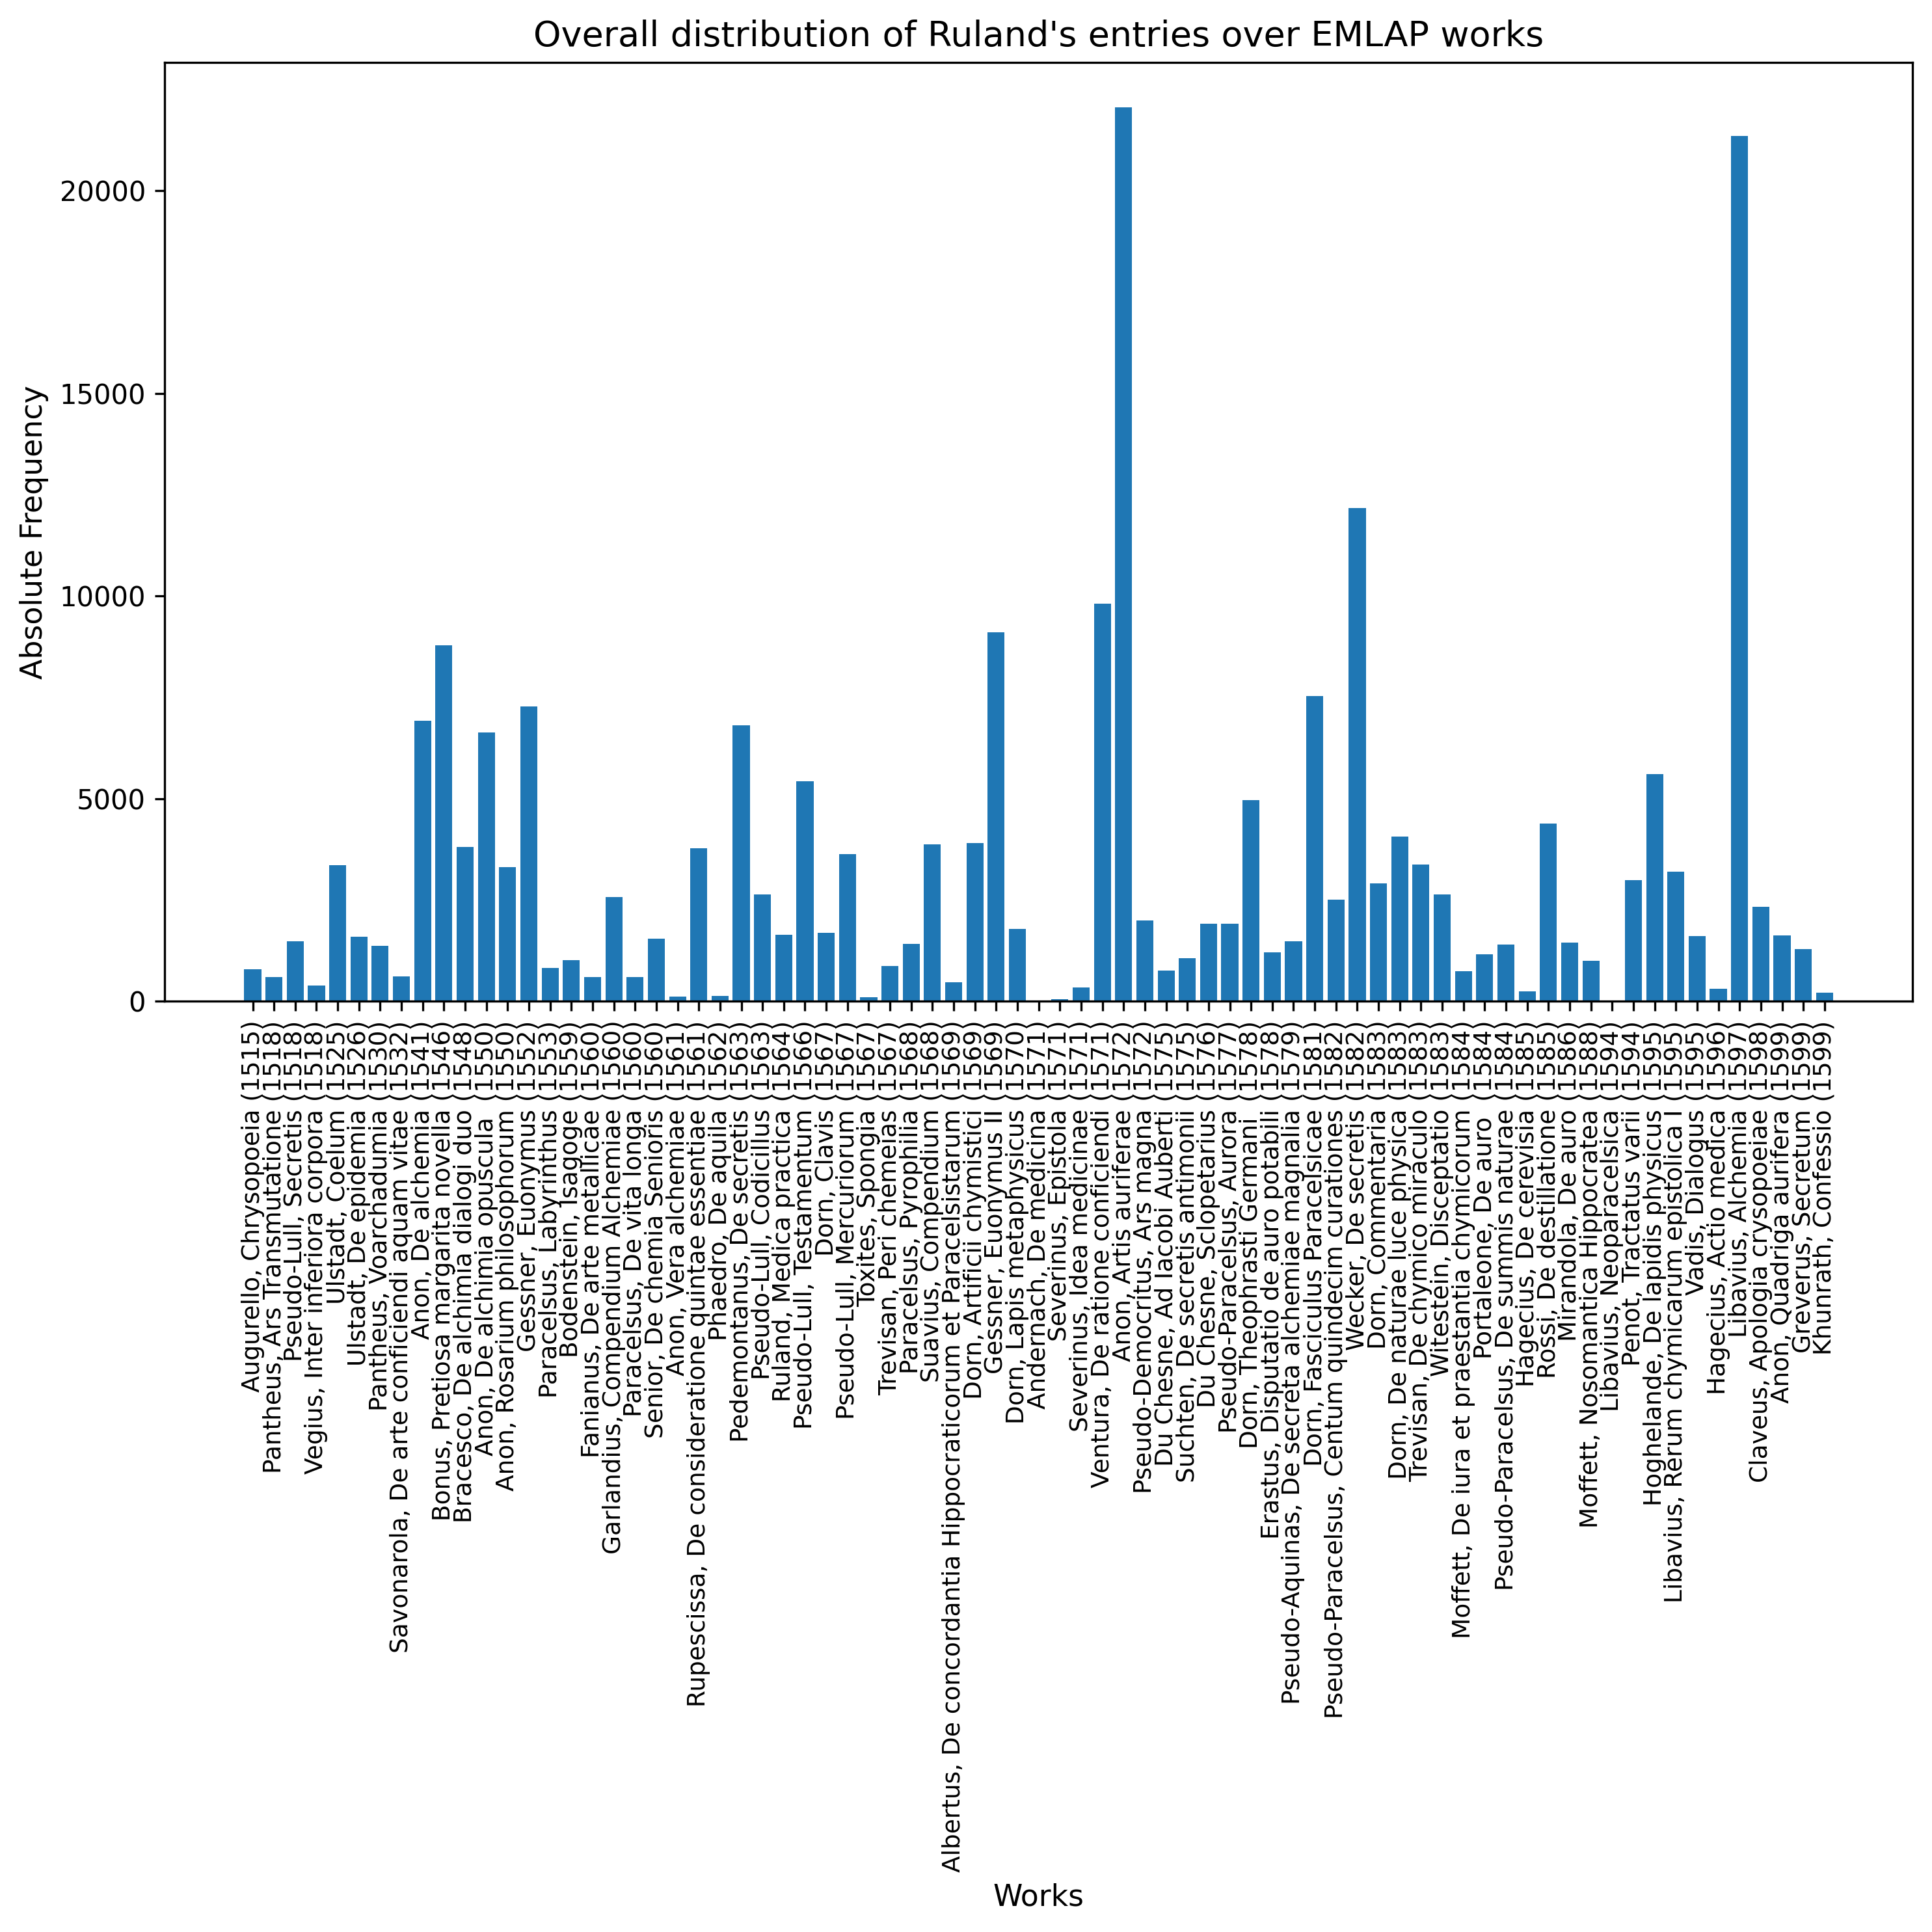

In [43]:
title = "Overall distribution of Ruland's entries over EMLAP works"

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300, tight_layout=True)

    # ax3-like: Absolute Frequency by works
ax.bar(x_pos, df["Frequency"].to_numpy())
ax.set_xlabel("Works", fontsize=11)
ax.set_ylabel("Absolute Frequency", fontsize=11)
ax.set_title(title, fontsize=13)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=90, fontsize=9)


In [44]:
fig.savefig("../figures/ruland-emlap-overall-distribution-absolute.png", dpi=300)

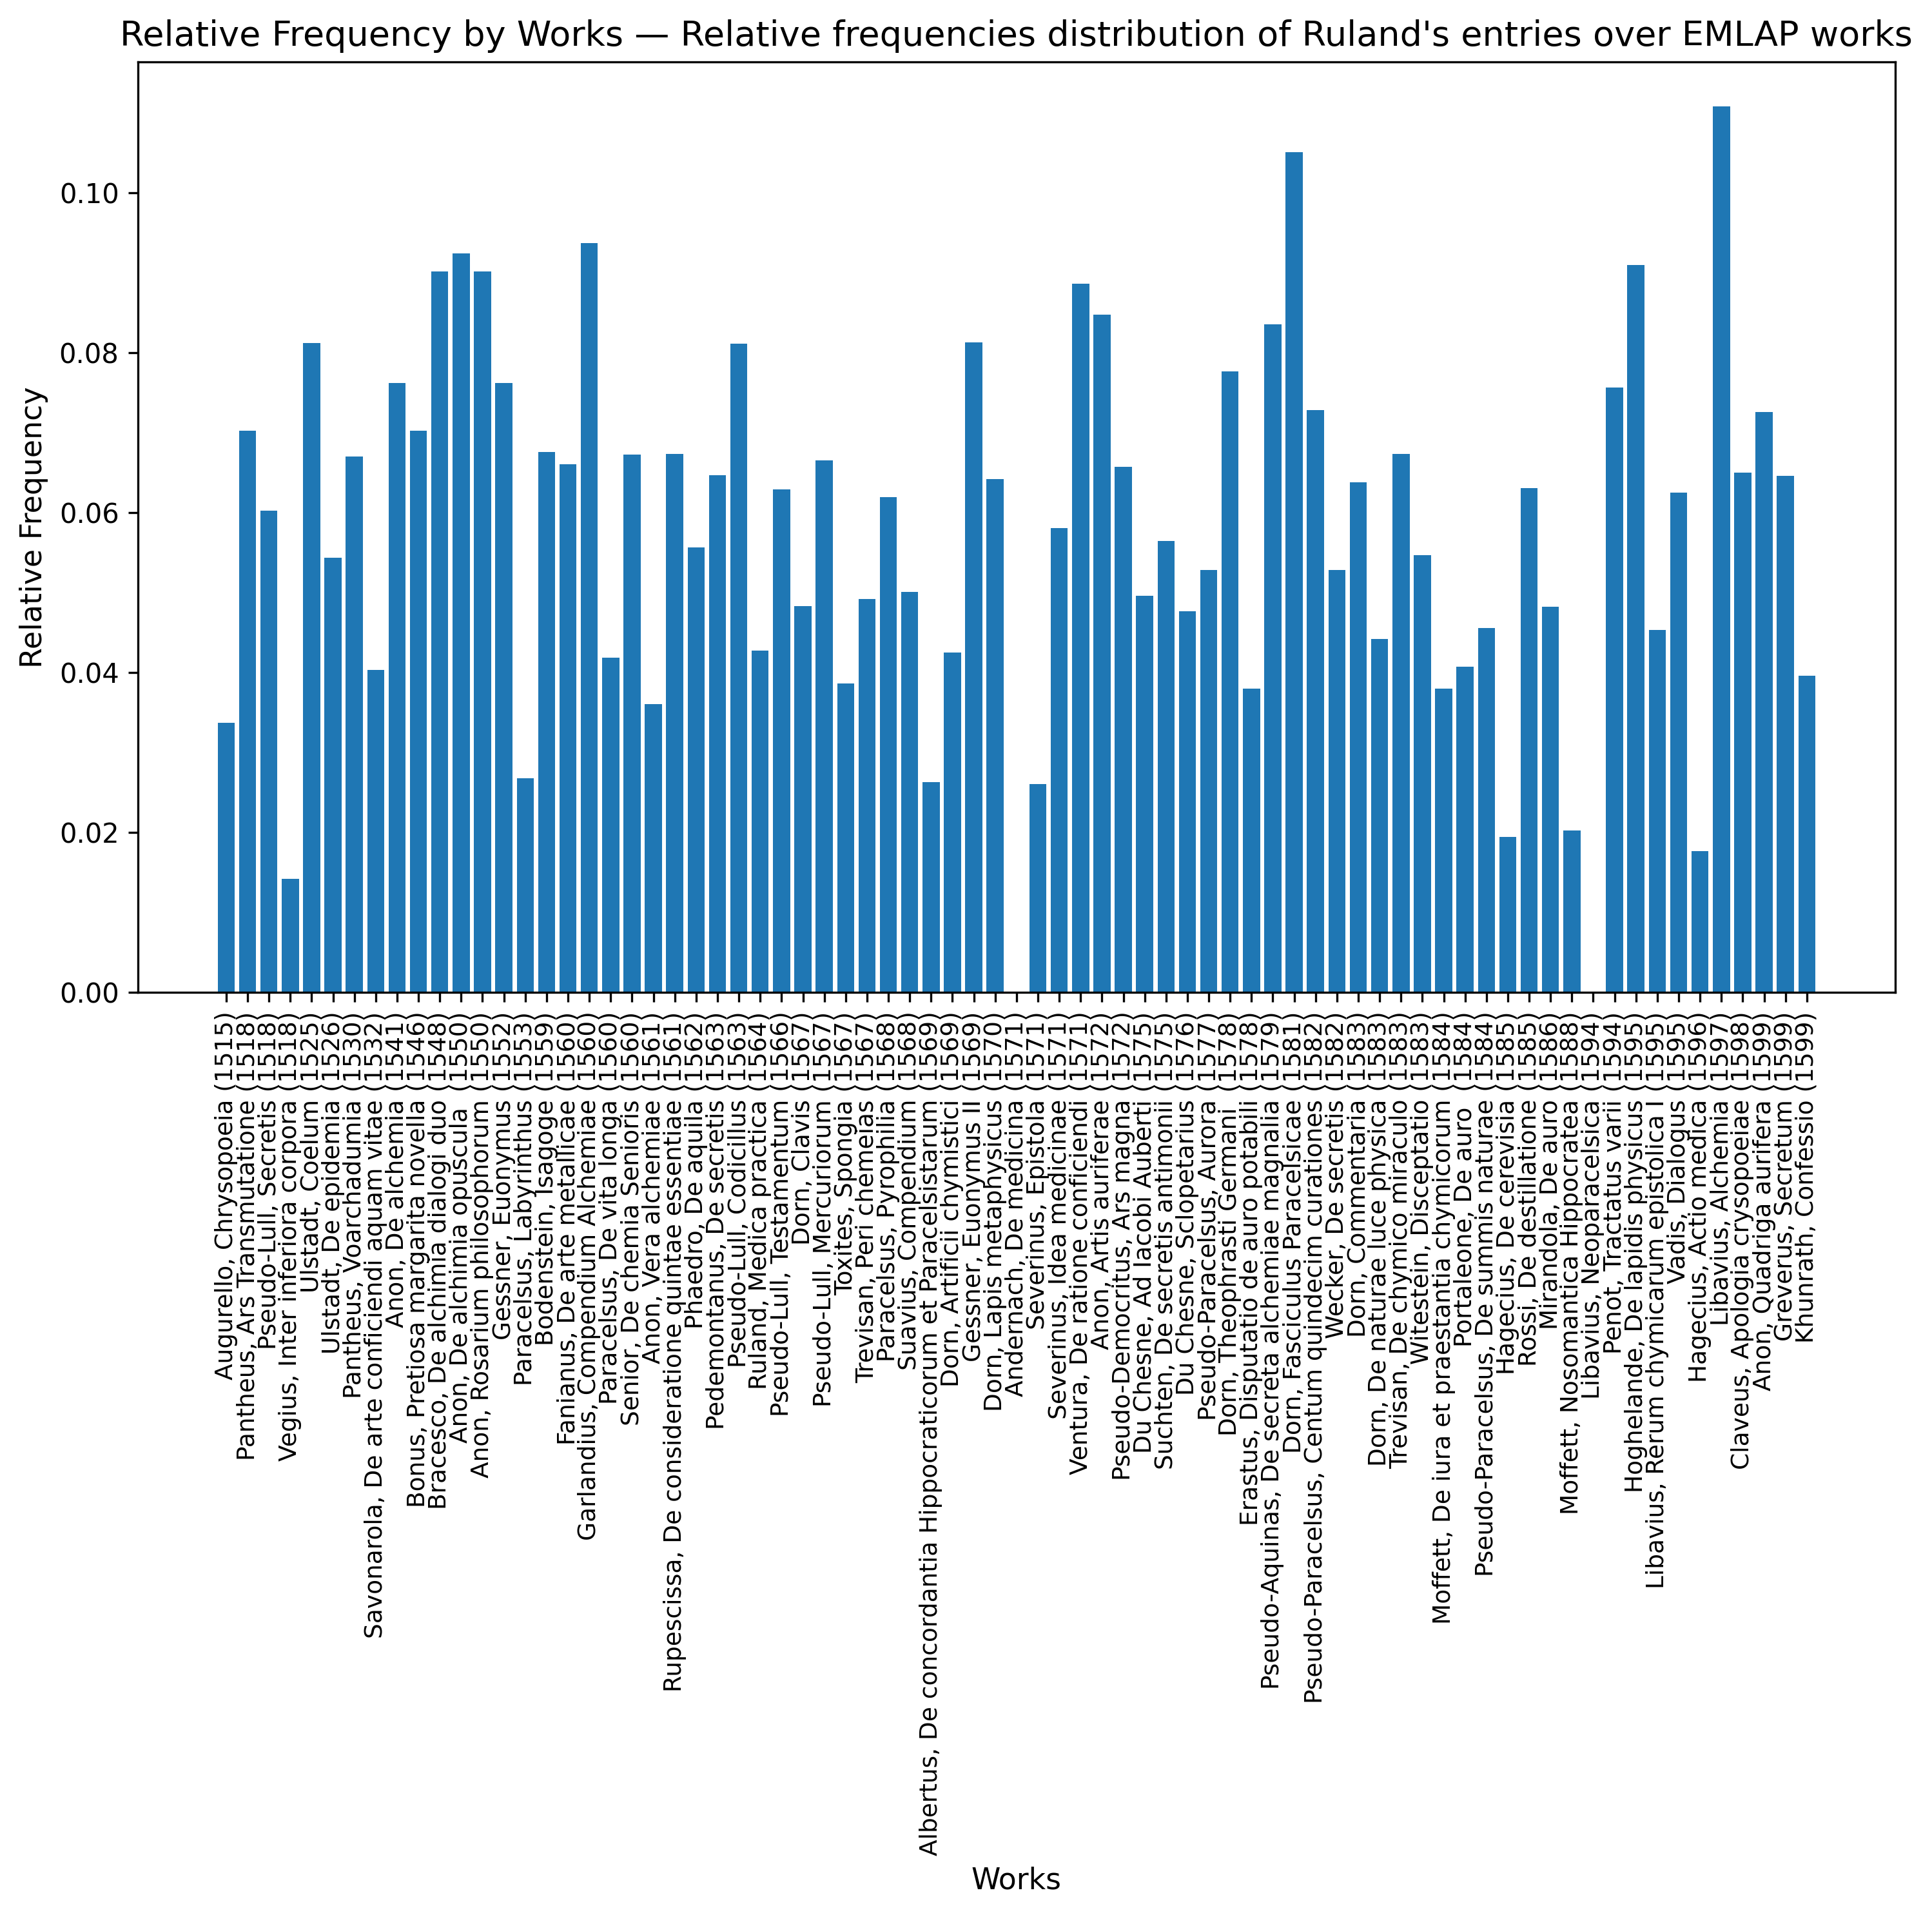

In [45]:
title = "Relative frequencies distribution of Ruland's entries over EMLAP works"
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300, tight_layout=True)

    # ax4-like: Relative Frequency by works
ax.bar(x_pos, df["RelativeFrequency"].to_numpy())
ax.set_xlabel("Works", fontsize=11)
ax.set_ylabel("Relative Frequency", fontsize=11)
ax.set_title(f"Relative Frequency by Works{f' — {title}' if title else ''}", fontsize=13)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=90, fontsize=9)

plt.tight_layout()
plt.show()

In [46]:
fig.savefig("../figures/ruland-emlap-overall-distribution-relative.png", dpi=300)

In [35]:
emlap_metadata["no."] = emlap_metadata["no."].astype(str)

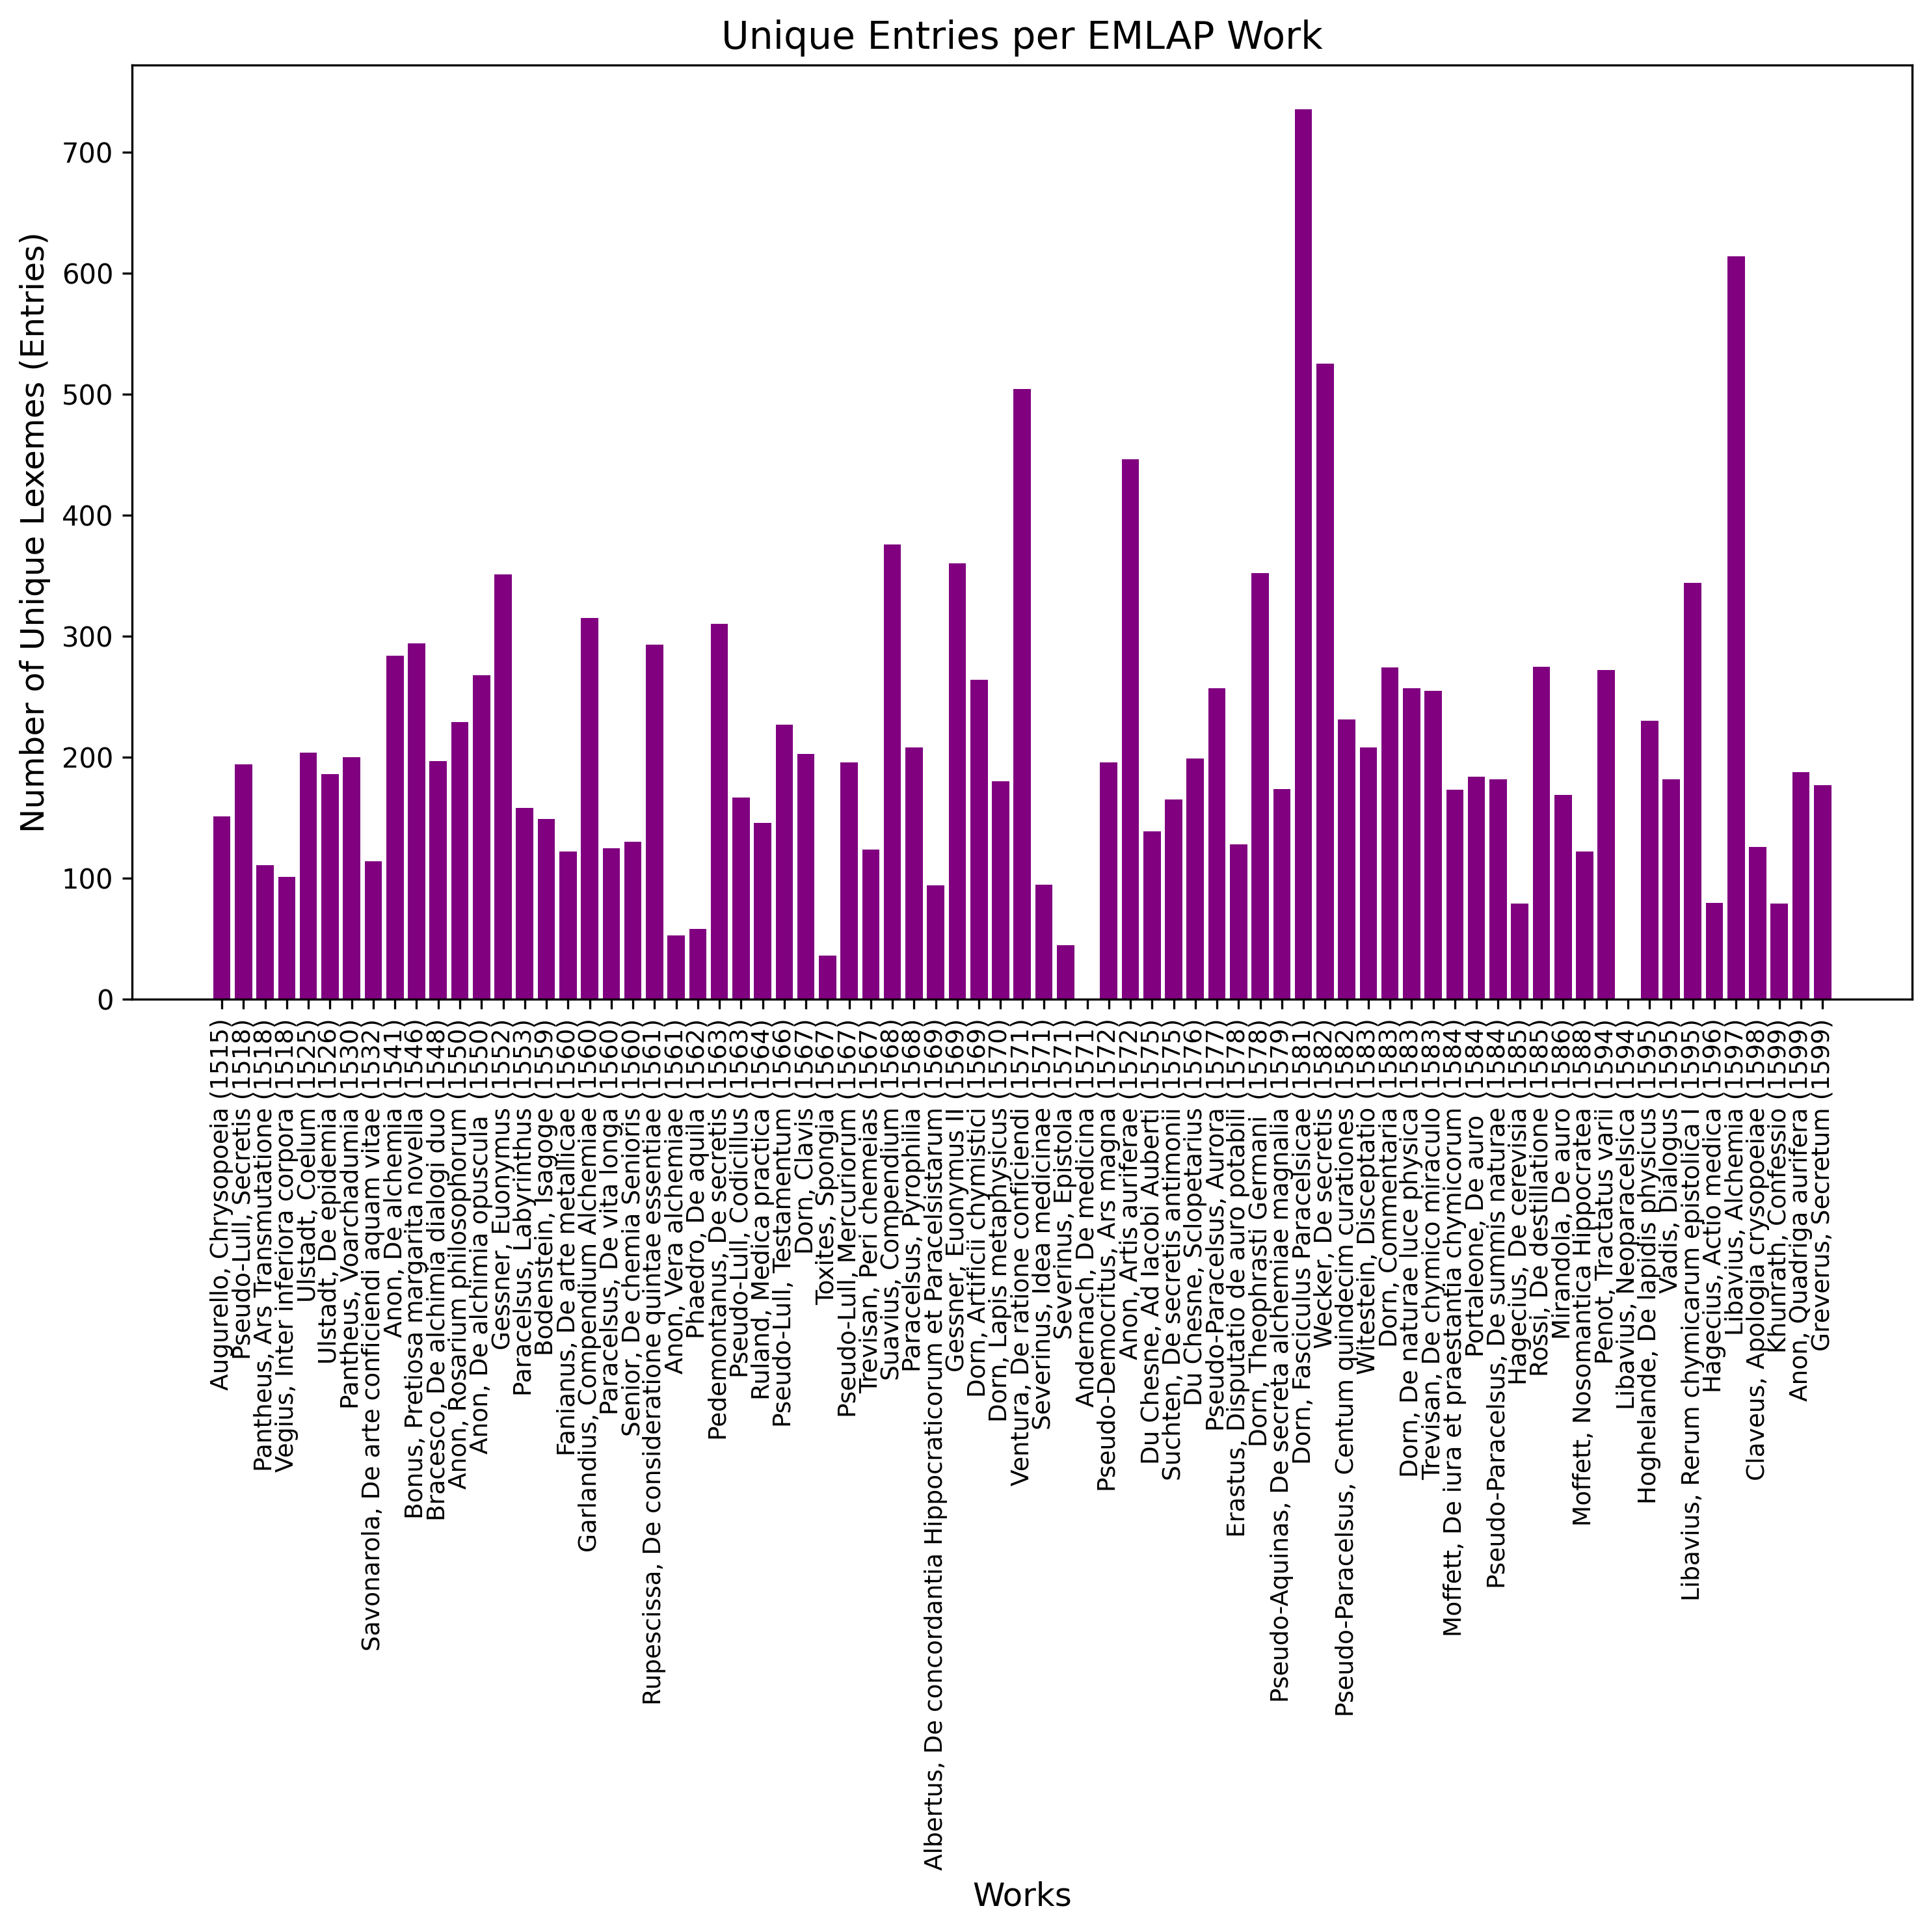

In [38]:
from collections import defaultdict

# 1) Initialize mapping: work_id → set of lexemes
work_to_lexemes = defaultdict(set)

# 2) Fill it: for each lexeme (row), add its Lemma to all works where it appears
for _, row in lexeme_df.iterrows():
    lemma = row["Lemma"]
    for work_id in row["instances_ids"]:
        work_to_lexemes[str(work_id)].add(lemma)

# 3) Build DataFrame with counts
work_entry_counts = (
    pd.DataFrame([
        {"no.": w, "unique_entries": len(lemmas)}
        for w, lemmas in work_to_lexemes.items()
    ])
)

# 4) Merge with emlap_metadata for titles, dates, etc.
work_entry_counts = emlap_metadata.merge(work_entry_counts, on="no.", how="left")
work_entry_counts["unique_entries"] = work_entry_counts["unique_entries"].fillna(0).astype(int)

# 5) Sort chronologically
work_entry_counts = work_entry_counts.sort_values("date_publication", na_position="last")

# 6) Plot — same style as ax3/ax4
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ax.bar(work_entry_counts["labeldate"], work_entry_counts["unique_entries"], color="purple")

ax.set_xlabel("Works", fontsize=12)
ax.set_ylabel("Number of Unique Lexemes (Entries)", fontsize=12)
ax.set_title("Unique Entries per EMLAP Work", fontsize=14)
ax.set_xticks(range(len(work_entry_counts["labeldate"])))
ax.set_xticklabels(work_entry_counts["labeldate"], rotation=90, fontsize=9)

plt.tight_layout()
plt.show()